In [ ]:
import datetime
import os
from collections import defaultdict

import torch
from torch import nn
from torch.nn import functional as F

from utils import *
from data.data import DataReader

import math
import numpy as np


###############################################
EXP_NAME = "Single-Batch-Overfit"
# TODO: When you change the model parameters, change the EXP_NAME!

# training parameters
BATCH_SIZE = 32
LR = 0.0005
EPOCHS = 1000
RESUME = False

# transformer parameters
TF_D_MODEL = 8
TF_DROPOUT = 0
TF_N_HEADS = 4
TF_DIM_FEEDFORWARD = 64
TF_ENC_LAYERS = 1
TF_DEC_LAYERS = 5

ADD_NOISE = False

# data and model path
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
SAVE_MODEL = 1
SAVE_MODEL_HISTORY = 10

PROCESED_DATA_DIR = "data/processed"
MODELS_DIR = os.path.join('saved_models', EXP_NAME)

model_architecture_path = os.path.join(MODELS_DIR, 'model.pth')
model_state_dict_path = os.path.join(MODELS_DIR, 'model_state_dict.pth')
def model_state_dict_epoch_path(epoch):
    return os.path.join(MODELS_DIR, 'model_state_dict_{}.pth'.format(epoch))

# strokes and characters
ALPHABET = [
    '\x00', ' ', '!', '"', '#', "'", '(', ')', ',', '-', '.',
    '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';',
    '?', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K',
    'L', 'M', 'N', 'O', 'P', 'R', 'S', 'T', 'U', 'V', 'W', 'Y',
    'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l',
    'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x',
    'y', 'z'
]
ALPHABET_SIZE = len(ALPHABET)
alphabet_ord = list(map(ord, ALPHABET))
alpha_to_num = defaultdict(int, list(map(reversed, enumerate(ALPHABET))))
num_to_alpha = dict(enumerate(alphabet_ord))

D_STROKE = 3

MAX_STROKE_LEN = 1200
MAX_CHAR_LEN = 75

In [44]:
class PositionalEncoding(nn.Module):
    "Implement the PE function."
    def __init__(self):
        super(PositionalEncoding, self).__init__()
        max_len = max(MAX_CHAR_LEN, MAX_STROKE_LEN)
        self.dropout = nn.Dropout(p=TF_DROPOUT)

        # Compute the positional encodings once in log space.
        pe = torch.zeros(max_len, TF_D_MODEL, requires_grad=False)
        position = torch.arange(0, max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, TF_D_MODEL, 2) *
                             -(math.log(10000.0) / TF_D_MODEL))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        with torch.no_grad():
            x = x + self.pe[:, :x.size(1)]
            return self.dropout(x)

class TFHW(nn.Module):

    def __init__(self) -> None:
        super(TFHW, self).__init__()

        self.src_embed = nn.Sequential(
            nn.Embedding(ALPHABET_SIZE, TF_D_MODEL),
            PositionalEncoding()
        )

        tf_encoder_layer = nn.TransformerEncoderLayer(
            d_model=TF_D_MODEL,
            nhead=TF_N_HEADS,
            dim_feedforward=TF_DIM_FEEDFORWARD,
            batch_first=True,
            dropout=TF_DROPOUT
        )

        self.encoder = nn.TransformerEncoder(
            encoder_layer=tf_encoder_layer,
            num_layers=TF_ENC_LAYERS,
            norm=nn.LayerNorm(TF_D_MODEL)
        )

        self.tgt_embed = nn.Sequential(
            nn.Linear(D_STROKE, TF_D_MODEL),
            PositionalEncoding()
        )

        tf_decoder_layer = nn.TransformerDecoderLayer(
            d_model=TF_D_MODEL,
            nhead=TF_N_HEADS,
            dim_feedforward=TF_DIM_FEEDFORWARD,
            dropout=TF_DROPOUT,
            batch_first=True,
        )

        self.decoder = nn.TransformerDecoder(
            decoder_layer=tf_decoder_layer,
            num_layers=TF_DEC_LAYERS,
            norm=nn.LayerNorm(TF_D_MODEL)
        )

        self.noise = torch.distributions.Normal(torch.tensor([0.0]), torch.tensor([1.0]))

        self.generator = nn.Linear(TF_D_MODEL, D_STROKE)

        #  TODO: init parameters randomly

    def forward(self, batch):

        batch_seq_char = batch['c']
        batch_seq_char_len = batch['c_len']
        batch_seq_stroke = batch['x']
        batch_seq_stroke_len = batch['x_len']

        encode_embed = self.src_embed(batch_seq_char)
        encoding = encode_embed

        # src_key_padding_mask = create_pad_mask(encode_embed, batch_seq_char_len).to(DEVICE)
        # encoding = self.encoder(src=encode_embed, src_key_padding_mask=src_key_padding_mask)

        decode_embed = self.tgt_embed(batch_seq_stroke)
        tgt_key_padding_mask = create_pad_mask(decode_embed, batch_seq_stroke_len).to(DEVICE)
        tgt_mask = self.create_mask(decode_embed.shape[1])

        decoding = self.decoder(
            tgt=decode_embed,
            tgt_mask=tgt_mask,
            memory=encoding,
            tgt_key_padding_mask=tgt_key_padding_mask
        )

        if ADD_NOISE:
            decoding = decoding + self.noise.sample(decoding.size()).squeeze().to(DEVICE)

        decode_strokes = self.generator(decoding)
        decode_strokes[:, :, -1] = torch.sigmoid(decode_strokes[:, :, -1])

        return decode_strokes


    def loss_fn(self, decode_strokes, batch):
        tgt_strokes = batch['y']
        
        mask = create_pad_mask(decode_strokes, batch['x_len']).to(DEVICE)
        
        coord_loss = F.mse_loss(tgt_strokes[..., :2], decode_strokes[..., :2], reduction="none")
        coord_mask = mask.unsqueeze(-1).expand(coord_loss.shape)
        coord_loss = coord_loss.masked_fill_(coord_mask, 0)
        coord_loss = torch.sum(coord_loss) / torch.sum(coord_mask == False)
        
        eos_loss = F.binary_cross_entropy(decode_strokes[..., -1],tgt_strokes[..., -1],  reduction='none')
        eos_loss = eos_loss.masked_fill_(mask, 0)
        eos_loss = torch.sum(eos_loss)/ torch.sum(mask == False)

        return coord_loss, eos_loss
    
    def predict(self, batch_seq_char, batch_seq_char_len, max_output_len=500):

        encode_embed = self.src_embed(batch_seq_char).to(DEVICE)
        src_key_padding_mask = create_pad_mask(encode_embed, batch_seq_char_len).to(DEVICE)
        encoding = self.encoder(src=encode_embed, src_key_padding_mask=src_key_padding_mask).to(DEVICE)

        output = torch.zeros(size=[1, max_output_len, 3]).to(DEVICE)
        output[0, 0, -1] = 1 # the starting point


        for t in range(1, max_output_len):
            tgt_emb = self.tgt_embed(output[:, :t]).to(DEVICE)
            tgt_mask = self.create_mask(tgt_emb.shape[1]).to(DEVICE)
            decoder_output = self.decoder(tgt=tgt_emb,
                                        memory=encoding,
                                        tgt_mask=tgt_mask).to(DEVICE)
            decoder_output =  self.generator(decoder_output[:, [-1], :])
            decoder_output[:, :, -1] = torch.sigmoid(decoder_output[:, :, -1])
            output[:, t, :] = decoder_output

        return output


    def create_mask(self, L) -> torch.tensor:
        return torch.triu(torch.full((L, L), float('-inf')), diagonal=1).to(DEVICE)


In [45]:
def train_loop(model, optimizer, batch):
    optimizer.zero_grad()
    output = model(batch)
    mse_loss, eos_loss = model.loss_fn(output, batch)
    loss = mse_loss  + eos_loss
    loss.backward()
    optimizer.step()
    return loss

In [ ]:
data_reader = DataReader("data/processed")
model = TFHW().to(DEVICE)
model.train()
optimizer = torch.optim.Adam(
    model.parameters(),
    lr=LR, betas=(0.0, 0.999), weight_decay=0, eps=1e-8
)

train_losses = []
val_losses = []

for epoch in range(EPOCHS):
    train_data = data_reader.train_batch_generator(BATCH_SIZE)
    val_data = data_reader.test_batch_generator(BATCH_SIZE)
    wandb_log = {}
    wandb_log["train_loss"] = 0

#     for batch in train_data:
    B, L, _ = batch['x'].shape
    loss = train_loop(model, optimizer, batch)
    wandb_log["train_loss"] += batch['x'].shape[0] * loss.item()
    print(wandb_log["train_loss"])
    train_losses.append(wandb_log['train_loss'])
        
#     with torch.no_grad():
#         wandb_log["val_loss"] = 0
        
#         for batch in val_data:
#             B, L, _ = batch['x'].shape
#             x = batch['x'][..., :L - 1, :2]
#             y = batch['x'][..., 1:, :2]
#             batch['x'] = x
#             batch['y'] = y
#             mse_loss = model.loss_fn(model(batch), batch)
#             loss = mse_loss 
#             wandb_log["val_loss"] += loss.item()
#     train_losses.append(wandb_log['val_loss'])
#     print(wandb_log)

In [26]:
with torch.no_grad():
    decode_strokes = model(batch)
    tgt_strokes = batch['y']

    mask = create_pad_mask(decode_strokes, batch['x_len']).to(DEVICE)

    coord_loss = F.mse_loss(tgt_strokes[..., :2], decode_strokes[..., :2], reduction="none")
    coord_mask = mask.unsqueeze(-1).expand(coord_loss.shape)
    coord_loss = coord_loss.masked_fill_(coord_mask, 0)
    coord_loss = torch.sum(coord_loss) / torch.sum(coord_mask == False)

    eos_loss = F.binary_cross_entropy(decode_strokes[..., -1],tgt_strokes[..., -1],  reduction='none')
    eos_loss = eos_loss.masked_fill_(mask, 0)
    eos_loss = torch.sum(eos_loss)/ torch.sum(mask == False)

In [33]:
x_len = batch['x_len'].item()
sqdiff = torch.square(tgt_strokes[:, :x_len, :2] - decode_strokes[:, :x_len, :2])
sqd = torch.sum(sqdiff)
print(coord_loss * torch.sum(coord_mask == False)) 
print(sqd)

tensor(148.0931, device='cuda:0')
tensor(148.0931, device='cuda:0')


In [38]:
tgt_strokes[:, :x_len, :2]

tensor([[[ 0.1970, -0.2660],
         [ 0.1404, -0.1231],
         [ 0.1256, -0.0468],
         ...,
         [ 0.2142,  1.1230],
         [-0.1428,  1.1131],
         [-0.3103,  0.8447]]], device='cuda:0')

In [37]:
decode_strokes[:, :x_len, :2]

tensor([[[ 0.0300, -0.2544],
         [ 0.0399, -0.2154],
         [ 0.0524, -0.2303],
         ...,
         [ 0.1370,  0.8144],
         [-0.3397,  0.7336],
         [-0.7605,  0.5473]]], device='cuda:0')

In [34]:
sqdiff

tensor([[[2.7894e-02, 1.3427e-04],
         [1.0099e-02, 8.5216e-03],
         [5.3617e-03, 3.3678e-02],
         ...,
         [5.9718e-03, 9.5194e-02],
         [3.8769e-02, 1.4401e-01],
         [2.0271e-01, 8.8415e-02]]], device='cuda:0')

In [ ]:
data_cols = ['x', 'x_len', 'c', 'c_len', 'w_id']
data_dir = "data/processed"
data = []

for col in data_cols:
    data.append(
        torch.from_numpy(
            np.load(os.path.join(data_dir, '{}.npy'.format(col)))
        ).to(DEVICE)
    )
data[2] = data[2].type(torch.int) # int8 is not compatible with Pytorch
data[1] -= 1
data.insert(1, data[0][:, 1:, :])
data_cols.insert(1, 'y')
data[0] = data[0][:, :-1, :]


batch = dict(zip(data_cols, [d[[0], ...] for d in data]))
print(batch["c_len"].shape)
print(batch["c_len"])

# data_reader = DataReader("data/processed")

In [ ]:
output = model(batch)
mask = create_pad_mask(output, batch['x_len'])
mask = mask.unsqueeze(-1)
mask = mask.expand(output.shape)
print(output.shape)
print(mask.shape)
print(mask)

In [ ]:
print(output)
output = output.masked_fill_(mask.to(DEVICE), 0)
print(output)

In [ ]:
batch['y'][:, :max(batch['x_len']), :]

In [ ]:
ALPHABET = [
    '\x00', ' ', '!', '"', '#', "'", '(', ')', ',', '-', '.',
    '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';',
    '?', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K',
    'L', 'M', 'N', 'O', 'P', 'R', 'S', 'T', 'U', 'V', 'W', 'Y',
    'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l',
    'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x',
    'y', 'z'
]
ALPHABET_SIZE = len(ALPHABET)
alphabet_ord = list(map(ord, ALPHABET))
alpha_to_num = defaultdict(int, list(map(reversed, enumerate(ALPHABET))))
num_to_alpha = dict(enumerate(alphabet_ord))

wrods = "hi my name is Peter he"
batch = {"c": torch.tensor([alpha_to_num[c] for c in wrods]).unsqueeze(0).to(DEVICE), "c_len": [len(wrods)]}

model_dir = "/home/bobby/final_proj/saved_models/Simple-HWTF"
model = torch.load(os.path.join(model_dir, "model.pth"))
model.load_state_dict(torch.load(os.path.join(model_dir, "model_state_dict.pth")))
model.to(DEVICE)
model.eval()
output = predict_no_guidance(model, batch)

In [ ]:
def predict(model, batch):
    """_summary_

    Args:
        batch_seq_char (N, L): sequence of character using the ALPHABET indexing
        batch_seq_char_len (N): lenght of each sequence in the batch
    """

    tgt = torch.zeros(size=[1, 1, 3]).to(DEVICE)
    L = batch['c_len'].item()
    sequence_length = L * 25

    with torch.no_grad():
        while tgt.shape[1] < sequence_length:
            tgt[0, 0, -1] = 1
            batch['x'] = tgt
            batch['x_len'] = np.asarray([tgt.shape[1]])
            tgt = model(batch)
            tgt = torch.cat([torch.zeros(size=[1, 1, 3]).to(DEVICE), tgt], 1)

    return tgt

In [47]:
output = predict(model, {'c': batch['c'], 'c_len': batch['c_len']})
print(output.shape)

torch.Size([1, 900, 3])


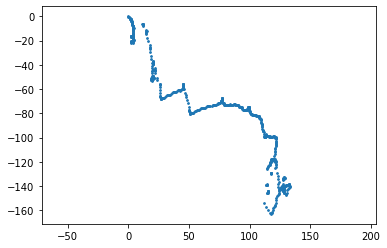

In [48]:
draw(output[:, :x_len, :], None)

In [ ]:
draw(batch['x'], None)

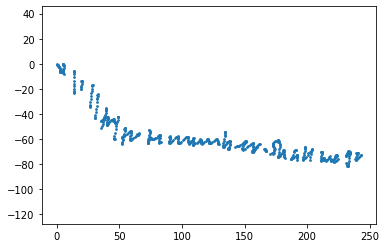

In [49]:
draw(model(batch)[:, :x_len, :], None)

In [ ]:
import matplotlib.pyplot as plt

def sequence_to_jpg(output, filename):
    output = output.cpu().detach()

    x = output.squeeze()
    abs_x = torch.cumsum(x, dim=0)

    coord_x = abs_x[:600, 0]
    coord_y = abs_x[:600, 1]
    plt.scatter(coord_x.cpu(), coord_y.cpu(), 3)
    plt.savefig(filename)
    plt.axis('equal')
    plt.show()

In [ ]:
sequence_to_jpg(output, "exp.jpg")

In [ ]:
[chr(num_to_alpha[n]) for n in batch['c'].squeeze().tolist()]

In [ ]:
alpha